In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt

csv_files = [
    ('BTC-USD.csv', 'BTC'),
    ('BNB-USD.csv', 'BNB'),
    ('ETH-USD.csv', 'ETH'),
    ('SOL-USD.csv', 'SOL'),
    ('XRP-USD.csv', 'XRP'),
    ('EURUSD=X.csv', 'EUR'),
    ('NYA.csv', 'NYA'),
    ('CMX.csv', 'Gold'),
    ('SNP.csv', 'S&P 500'),
]

In [2]:
from utils.reader import CryptoCsvReader
from utils.plotter import Plotter

In [6]:
from mfn.entropy import MFN


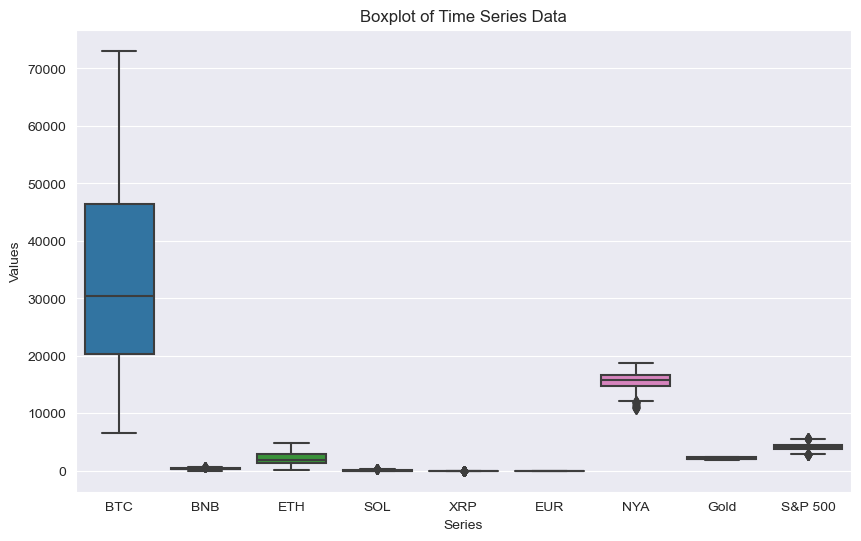

In [3]:
from matplotlib import pyplot as plt

time_series_list = []

for path, name in csv_files:
    data = pd.read_csv(f'data/{path}')
    data = data[['Close']].to_numpy()
    time_series_list.append((data, name))

time_series = [x[0] for x in time_series_list]
labels = [x[1] for x in time_series_list]
plt.figure(figsize=(10, 6))
sns.boxplot(data=time_series)
plt.xticks(range(len(labels)), labels)  # Set x-axis labels
plt.title('Boxplot of Time Series Data')
plt.xlabel('Series')
plt.ylabel('Values')
plt.show() 

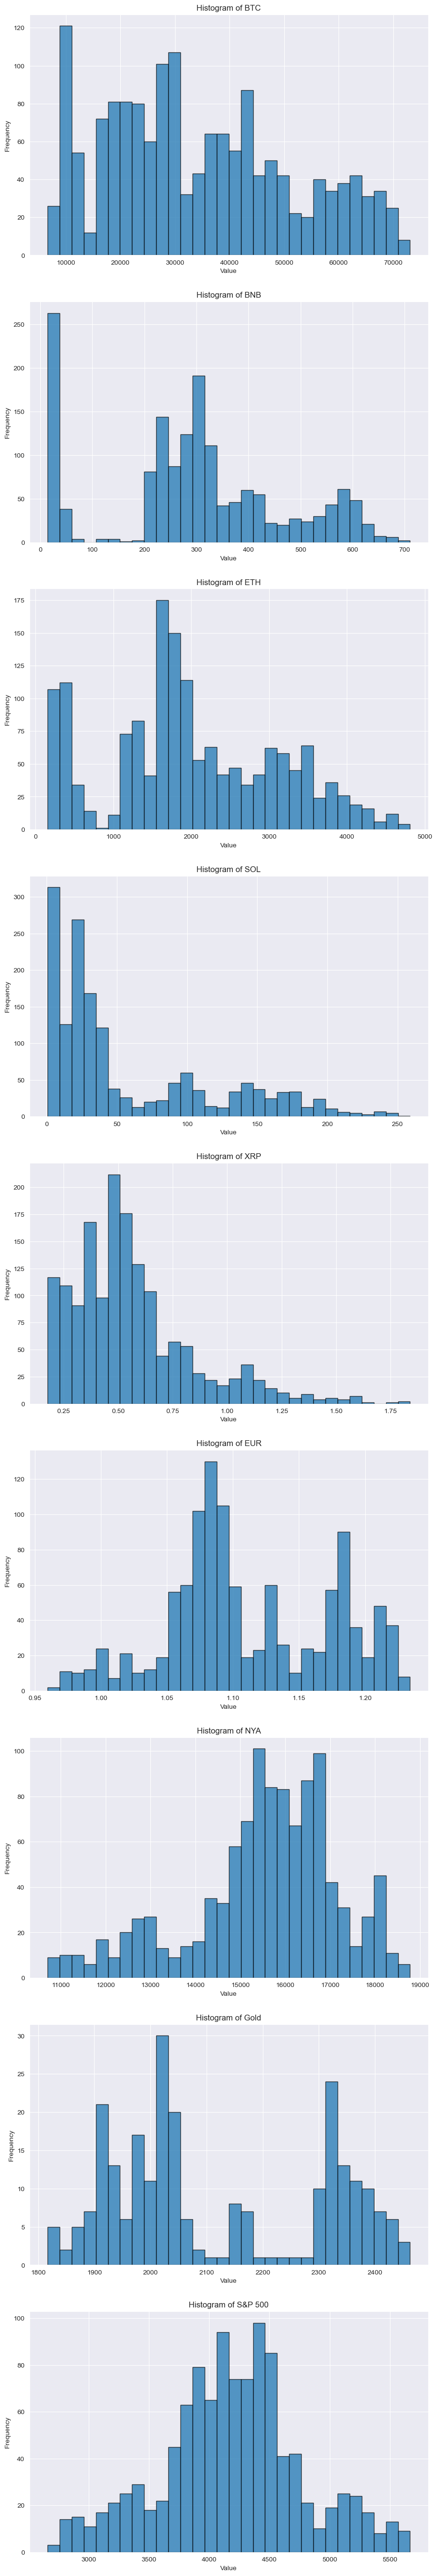

In [4]:
fig, axes = plt.subplots(nrows=len(time_series_list), ncols=1, figsize=(10, 6 * len(time_series_list)))
fig.tight_layout(pad=5.0)

for ax, (data, name) in zip(axes, time_series_list):
    ax.hist(data, bins=30, alpha=0.75, edgecolor='black')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.show()

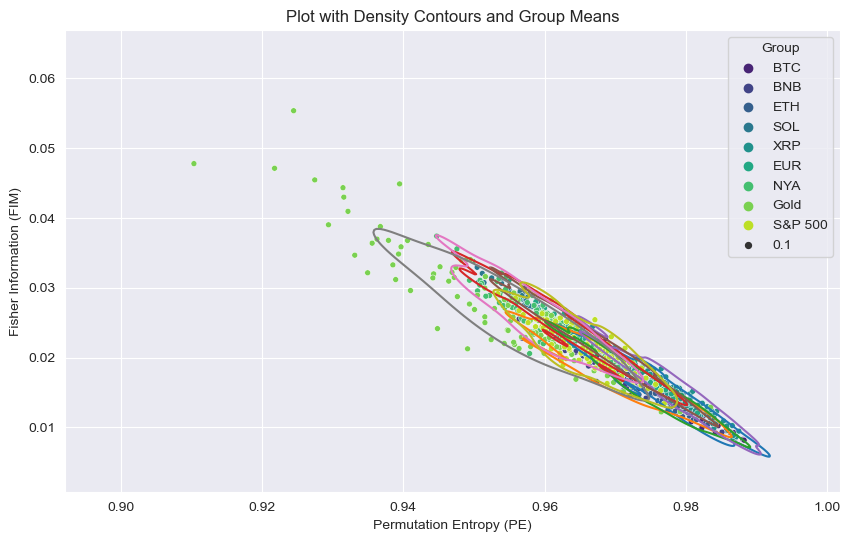

In [9]:
# OProcess each CSV file

points = []

for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    # Append all values for each file
    pe_values = value_dict['permutation entropy']
    fim_values = value_dict['fisher information']
    for pe, fim in zip(pe_values, fim_values):
        points.append((pe, fim, name))

# Convert points list to a DataFrame
df = pd.DataFrame(points, columns=['PE', 'FIM', 'group'])

# Plotting
plt.figure(figsize=(10, 6))

# Density contours
sns.kdeplot(data=df, x='PE', y='FIM', hue='group', levels=1, color='k')

# Points
sns.scatterplot(data=df, x='PE', y='FIM', hue='group', size=0.1, palette='viridis')
plt.title('Plot with Density Contours and Group Means')
plt.xlabel('Permutation Entropy (PE)')
plt.ylabel('Fisher Information (FIM)')
plt.legend(title='Group')
plt.show()

In [ ]:


from mfn.entropy import MFN

means = []

for f, name in csv_files:
    reader = CryptoCsvReader(f'data/{f}')
    time_series = reader.read()
    value_dict = MFN(
        time_series,
        b=10,
        B=.1,
        size=100,
        dx=3
    )
    pe = np.mean(value_dict['permutation entropy'])
    fim = np.mean(value_dict['fisher information'])
    p = (pe, fim)
    means.append((p, name))

x = [point[0] for point, _ in means]  # Permutation Entropy
y = [point[1] for point, _ in means]  # Fisher Information Measure
labels = [name for _, name in means]  # Labels

# Plotting the points
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', alpha=0.6)

# Adding labels to the points
for i, label in enumerate(labels):
    plt.text(x[i], y[i], label, fontsize=9, ha='right')

# Setting the axis labels and title
plt.xlabel('Permutation Entropy')
plt.ylabel('Fisher Information Measure')
plt.title('Permutation Entropy vs. Fisher Information Measure')
plt.grid(True)
plt.show()